In [6]:
from tqdm import tqdm

In [7]:
import os
import numpy as np
import numpy.random as rnd
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from scipy.special import softmax
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score
from sklearn.preprocessing import label_binarize
from typing import List, Tuple, TypeVar
from sklearn.metrics.pairwise import rbf_kernel as RBF_PW

from errors import sECE, accuracy

def ECE(*args, **kwargs):
    return sECE(*args, **kwargs)**.5

def SKCE_vector(kernel, predictions, outcomes):

    def SKCE_vectorized_helper(i,j):
        matrix_kernel = k_g_Xi_g_Xj[i,j] * np.eye(len(predictions[i]))
        return ((diff_outcomes_preds[i] @ matrix_kernel) @ np.array(diff_outcomes_preds[j]).T)

    predictions = np.array(predictions)
    outcomes = np.array(outcomes)
    n = len(outcomes)

    # Compute the kernel matrix for the pair
    k_g_Xi_g_Xj = kernel(predictions, predictions)

    # Compute the difference between unit vectors outcomes and predictions
    diff_outcomes_preds = np.array(outcomes - predictions)

    indices_upper_triangular = np.triu_indices(n, k=1)

    vhelper = np.vectorize(SKCE_vectorized_helper)
    results = vhelper(indices_upper_triangular[0], indices_upper_triangular[1])
    skce = np.sum(results)


    # Divide the SKCE by n over 2
    prefactor = (n* (n-1)) // 2
    skce /= prefactor

    return skce


def transform_outcomes(predictions, outcomes):
    #creates vector for outcomes to match predictions shape
    #outcomes_minus_one = [x - 1 for x in outcomes]
    transformed_outcomes = np.zeros_like(predictions)
    transformed_outcomes[np.arange(len(predictions)), outcomes] = 1
    return transformed_outcomes

# Use the rbf_kernel function from sklearn.metrics.pairwise
def rbf_pw(X, Y=None, length_scale=1.0):
    gamma = 1.0 / (2 * length_scale ** 2)
    return RBF_PW(X, Y, gamma=gamma)
results_dir = 'plots/'

In [8]:
np.random.seed(1)
# amount of classes
C = 100
# amount of val samples
n_val = 10000
# amount of test samples
n_test = 10000
# scaling of the scale matrix to adjust accuracy of the simulation
# lower s -> higher acc; and vice versa
s = .01
# class means (we assume each multivariate mean is a one-hot vector)
eye = np.eye(C)
# sample covariance matrizes from a inv wishart distribution to avoid accidental cherry picking
cov_matrizes = stats.invwishart(scale=eye/s).rvs(size=C)
logits = []

for i in range(C):
    # sample class conditional logits from a multivariate normal dist
    logits.append(stats.multivariate_normal(mean=eye[i], cov=cov_matrizes[i]).rvs(int((n_val+n_test)/C)))

logits = np.concatenate(logits)
labels = []
for logit in logits:
    # since the logits are normal distributed, the probs are logistic normal distributed
    probs = softmax(logit)
    labels.append(np.random.choice(np.arange(C), size=1, p=probs))
    
labels = np.array(labels).flatten()

logits_val = logits[:n_val]
labels_val = labels[:n_val]
logits_test = logits[n_val:]
labels_test = labels[n_val:]

In [9]:
# check for realistic accuracy
acc = accuracy(logits_val, labels_val)
print(acc)

0.8763


In [10]:
def experiment(logits, labels, start_rep=1000, start_n=100, n=3000, n_ticks=10, seed=1):
    np.random.seed(seed)
    sizes = np.rint(np.flip(np.logspace(np.log2(start_n), np.log2(n), n_ticks, base=2))).astype(int)
    # quadratically decrease repetitions
    repetitions = np.rint(np.linspace(1, np.sqrt(start_rep), n_ticks) ** 2).astype(int)

    repeated_sizes = [s for s, r in zip(sizes, repetitions) for _ in range(r)]
    results = pd.DataFrame(columns=['method', 'value', 'size', 'error'])

    for s in tqdm(repeated_sizes):
        indices = np.random.choice(n, size=s, replace=False)
        ls = logits[indices]
        ys = labels[indices]
        ece_0 = ECE(ls, ys)
        ece_1 = ECE(ls * 1.5, ys)
        ece_2 = ECE(ls * 2.5, ys)
        
        run = pd.DataFrame({
            'ECE': [ece_0, ece_1, ece_2],
            'Size': [s, s, s],
            'Calibration': ['Perfect', 'Mediocre', 'Bad']
        })

        results = pd.concat([results, run]).reset_index(drop=True)
    return results

In [11]:
results = experiment(logits_test, labels_test)

100%|██████████| 3615/3615 [00:39<00:00, 91.66it/s] 


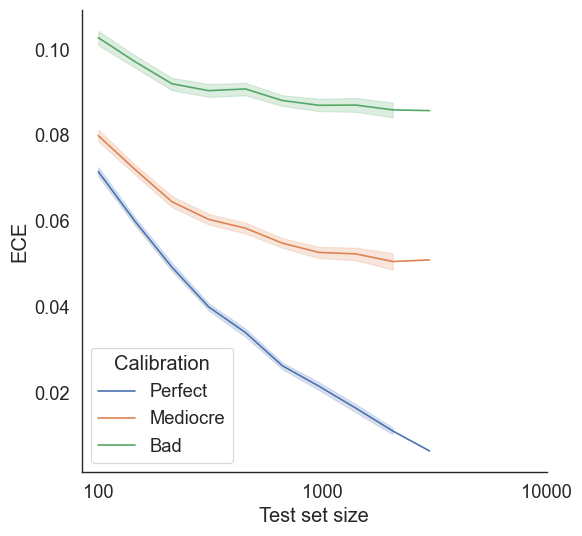

In [12]:
# larger version of Figure 2 in paper
df = results
ticks = [100, 1000, 10000]
rc = {'figure.figsize': (6, 6)}
font_scale = 1.5
sns.set(rc=rc, font_scale=font_scale, context='paper')
sns.set_style("white")
plot = sns.lineplot(data=df, x='Size', y='ECE', hue='Calibration')
plot.set(
    xscale='log', xticks=ticks, xticklabels=ticks, xlabel='Test set size')
sns.despine(left=False, bottom=False)

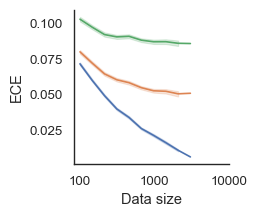

In [13]:
# Figure 2 in paper
df = results
ticks = [100, 1000, 10000]
rc = {'figure.figsize': (2, 2)}
font_scale = 1.1
sns.set(rc=rc, font_scale=font_scale, context='paper')
sns.set_style("white")
plot = sns.lineplot(data=df, x='Size', y='ECE', hue='Calibration')
plot.set(
    xscale='log', xticks=ticks, xticklabels=ticks, xlabel='Data size')
plot.legend([], [], frameon=False)
sns.despine(left=False, bottom=False)

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

plot.figure.savefig(results_dir + 'ece_sim.pdf', bbox_inches = "tight")

In [14]:
from joblib import Parallel, delayed

def experiment_skce(logits, labels, start_rep=1000, start_n=100, n=10000, n_ticks=10, seed=1):
    def compute_SKCE(s):
        indices = np.random.choice(logits.shape[0], size=s, replace=False)
        ls = logits[indices]
        ys = labels[indices]
        probs = softmax(ls, axis=1)

        skce_0 = SKCE_vector(rbf_pw, probs, label_binarize(ys, classes=np.arange(C)))
        skce_1 = SKCE_vector(rbf_pw, probs * 1.5, label_binarize(ys, classes=np.arange(C)))
        skce_2 = SKCE_vector(rbf_pw, probs * 2.5, label_binarize(ys, classes=np.arange(C)))
        skce_3 = SKCE_vector(rbf_pw, probs / 1.5, label_binarize(ys, classes=np.arange(C)))
        skce_4 = SKCE_vector(rbf_pw, probs / 2.5, label_binarize(ys, classes=np.arange(C)))

        return pd.DataFrame({
            'SKCE': [skce_0, skce_1, skce_2, skce_3, skce_4],
            'Size': [s, s, s, s, s],
            'Calibration': ['Perfect', 'Mediocre', 'Bad', 'Neg. Mediocre', 'Neg. Bad']
        })

    np.random.seed(seed)
    sizes = np.rint(np.flip(np.logspace(np.log2(start_n), np.log2(n), n_ticks, base=2))).astype(int)
    repetitions = np.rint(np.linspace(1, np.sqrt(start_rep), n_ticks) ** 2).astype(int)

    repeated_sizes = [s for s, r in zip(sizes, repetitions) for _ in range(r)]
    results = pd.DataFrame(columns=['SKCE', 'Size', 'Calibration'])

    runs = Parallel(n_jobs=-1, verbose=5)(delayed(compute_SKCE)(s) for s in repeated_sizes)
    for run in runs:
        results = pd.concat([results, run]).reset_index(drop=True)

    return results


In [20]:
"""def experiment_skce(logits, labels, start_rep=1000, start_n=100, n=3000, n_ticks=10, seed=1):
    np.random.seed(seed)
    sizes = np.rint(np.flip(np.logspace(np.log2(start_n), np.log2(n), n_ticks, base=2))).astype(int)
    # quadratically decrease repetitions
    repetitions = np.rint(np.linspace(1, np.sqrt(start_rep), n_ticks) ** 2).astype(int)

    repeated_sizes = [s for s, r in zip(sizes, repetitions) for _ in range(r)]
    results = pd.DataFrame(columns=['method', 'value', 'size', 'error'])

    for s in tqdm(repeated_sizes):
        indices = np.random.choice(n, size=s, replace=False)
        ls = logits[indices]
        ys = labels[indices]
        probs = softmax(ls, axis=1)

        skce_0 = SKCE_vector(rbf_pw, probs, label_binarize(ys, classes=np.arange(C)))
        skce_1 = SKCE_vector(rbf_pw, probs * 1.5, label_binarize(ys, classes=np.arange(C)))
        skce_2 = SKCE_vector(rbf_pw, probs * 2.5, label_binarize(ys, classes=np.arange(C)))

        run = pd.DataFrame({
            'SKCE': [skce_0, skce_1, skce_2],
            'Size': [s, s, s],
            'Calibration': ['Perfect', 'Mediocre', 'Bad']
        })

        results = pd.concat([results, run]).reset_index(drop=True)
    return results"""


"def experiment_skce(logits, labels, start_rep=1000, start_n=100, n=3000, n_ticks=10, seed=1):\n    np.random.seed(seed)\n    sizes = np.rint(np.flip(np.logspace(np.log2(start_n), np.log2(n), n_ticks, base=2))).astype(int)\n    # quadratically decrease repetitions\n    repetitions = np.rint(np.linspace(1, np.sqrt(start_rep), n_ticks) ** 2).astype(int)\n\n    repeated_sizes = [s for s, r in zip(sizes, repetitions) for _ in range(r)]\n    results = pd.DataFrame(columns=['method', 'value', 'size', 'error'])\n\n    for s in tqdm(repeated_sizes):\n        indices = np.random.choice(n, size=s, replace=False)\n        ls = logits[indices]\n        ys = labels[indices]\n        probs = softmax(ls, axis=1)\n\n        skce_0 = SKCE_vector(rbf_pw, probs, label_binarize(ys, classes=np.arange(C)))\n        skce_1 = SKCE_vector(rbf_pw, probs * 1.5, label_binarize(ys, classes=np.arange(C)))\n        skce_2 = SKCE_vector(rbf_pw, probs * 2.5, label_binarize(ys, classes=np.arange(C)))\n\n        run = p

In [15]:
results = experiment_skce(logits_test, labels_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 50.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 64.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 77.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 85.4min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 91.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 95.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 98.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 102.2min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 104.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 106.1min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 107.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 108.3min
[Parallel(n_jobs=-1)]: Done 3615 out of 3615

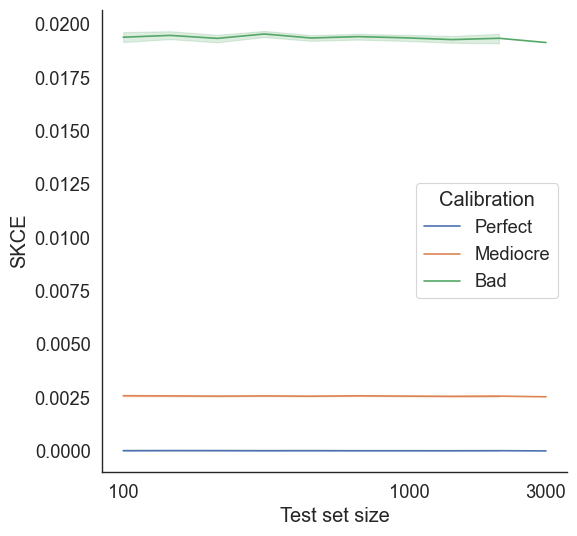

In [19]:

# Plot SKCE instead of ECE
df = results
ticks = [100, 1000, 10000]
rc = {'figure.figsize': (6, 6)}
font_scale = 1.5
sns.set(rc=rc, font_scale=font_scale, context='paper')
sns.set_style("white")
plot = sns.lineplot(data=df, x='Size', y='SKCE', hue='Calibration')
plot.set(
    xscale='log', xticks=ticks, xticklabels=ticks, xlabel='Test set size')
sns.despine(left=False, bottom=False)


In [17]:
fig = plot.get_figure()
fig.savefig("full_exp.png")

In [20]:
plot.figure.savefig("alternative_exp.png")

In [12]:
logits_test[1]

In [13]:
labels_test[1]

In [14]:
transformed = transform_outcomes(logits_test,labels_test)

In [15]:
transformed[1]

In [16]:
label_binarize([labels_test[1]], classes=np.arange(C))